# YOLO Architecture

### Model

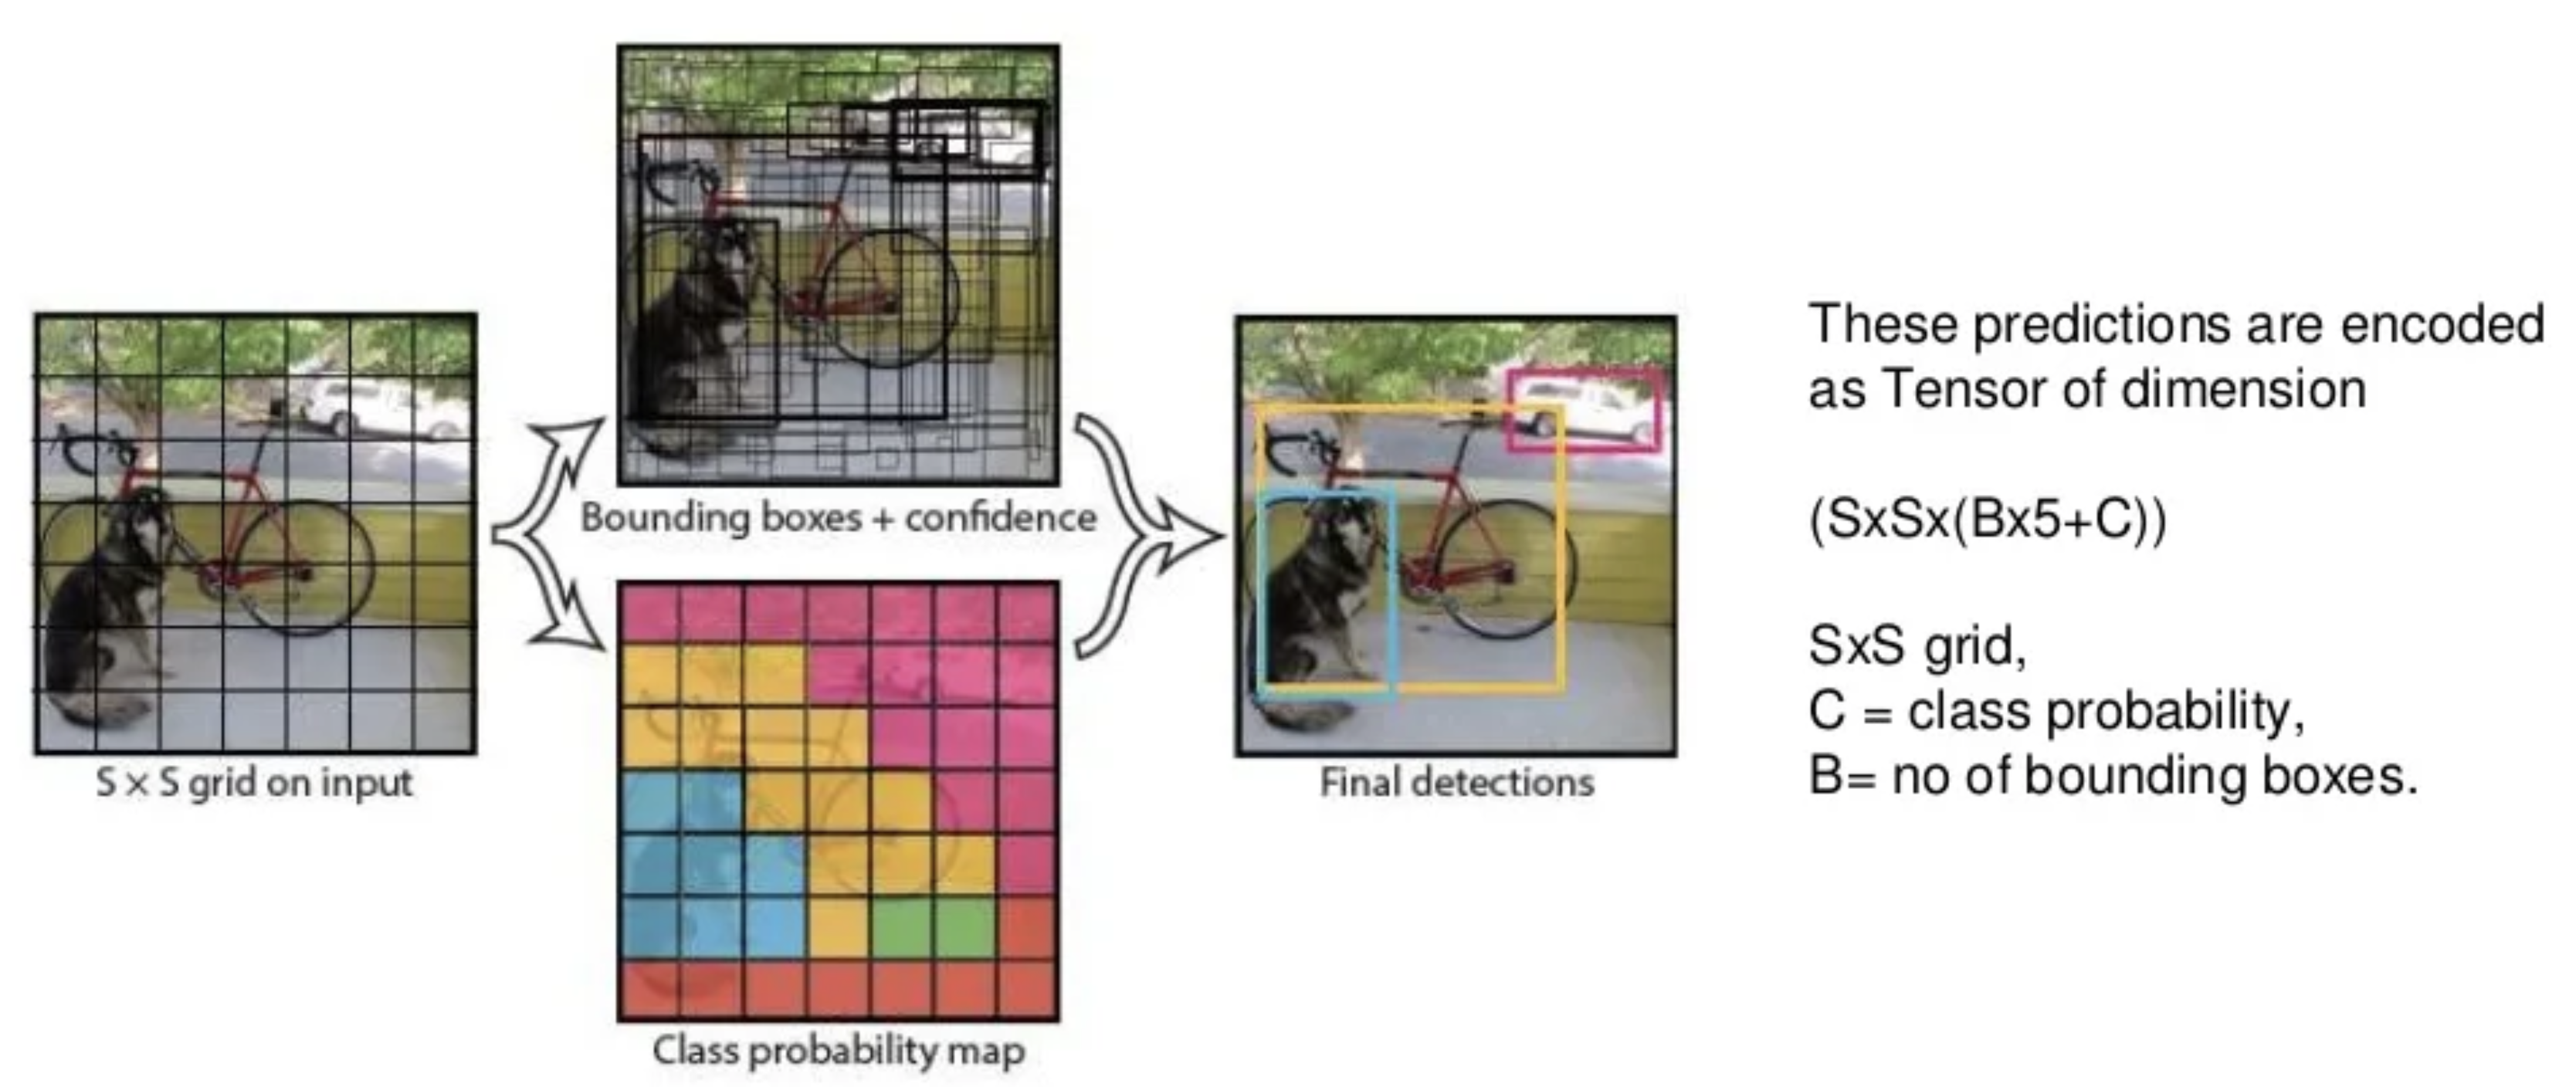

## Network Design

- Inspired by `GoogLeNet` (image classification)
- *24* convolutional layers followed by 2 fully connected layers
- Fast `YOLO` uses **9** convolutional layers (instead of 24)

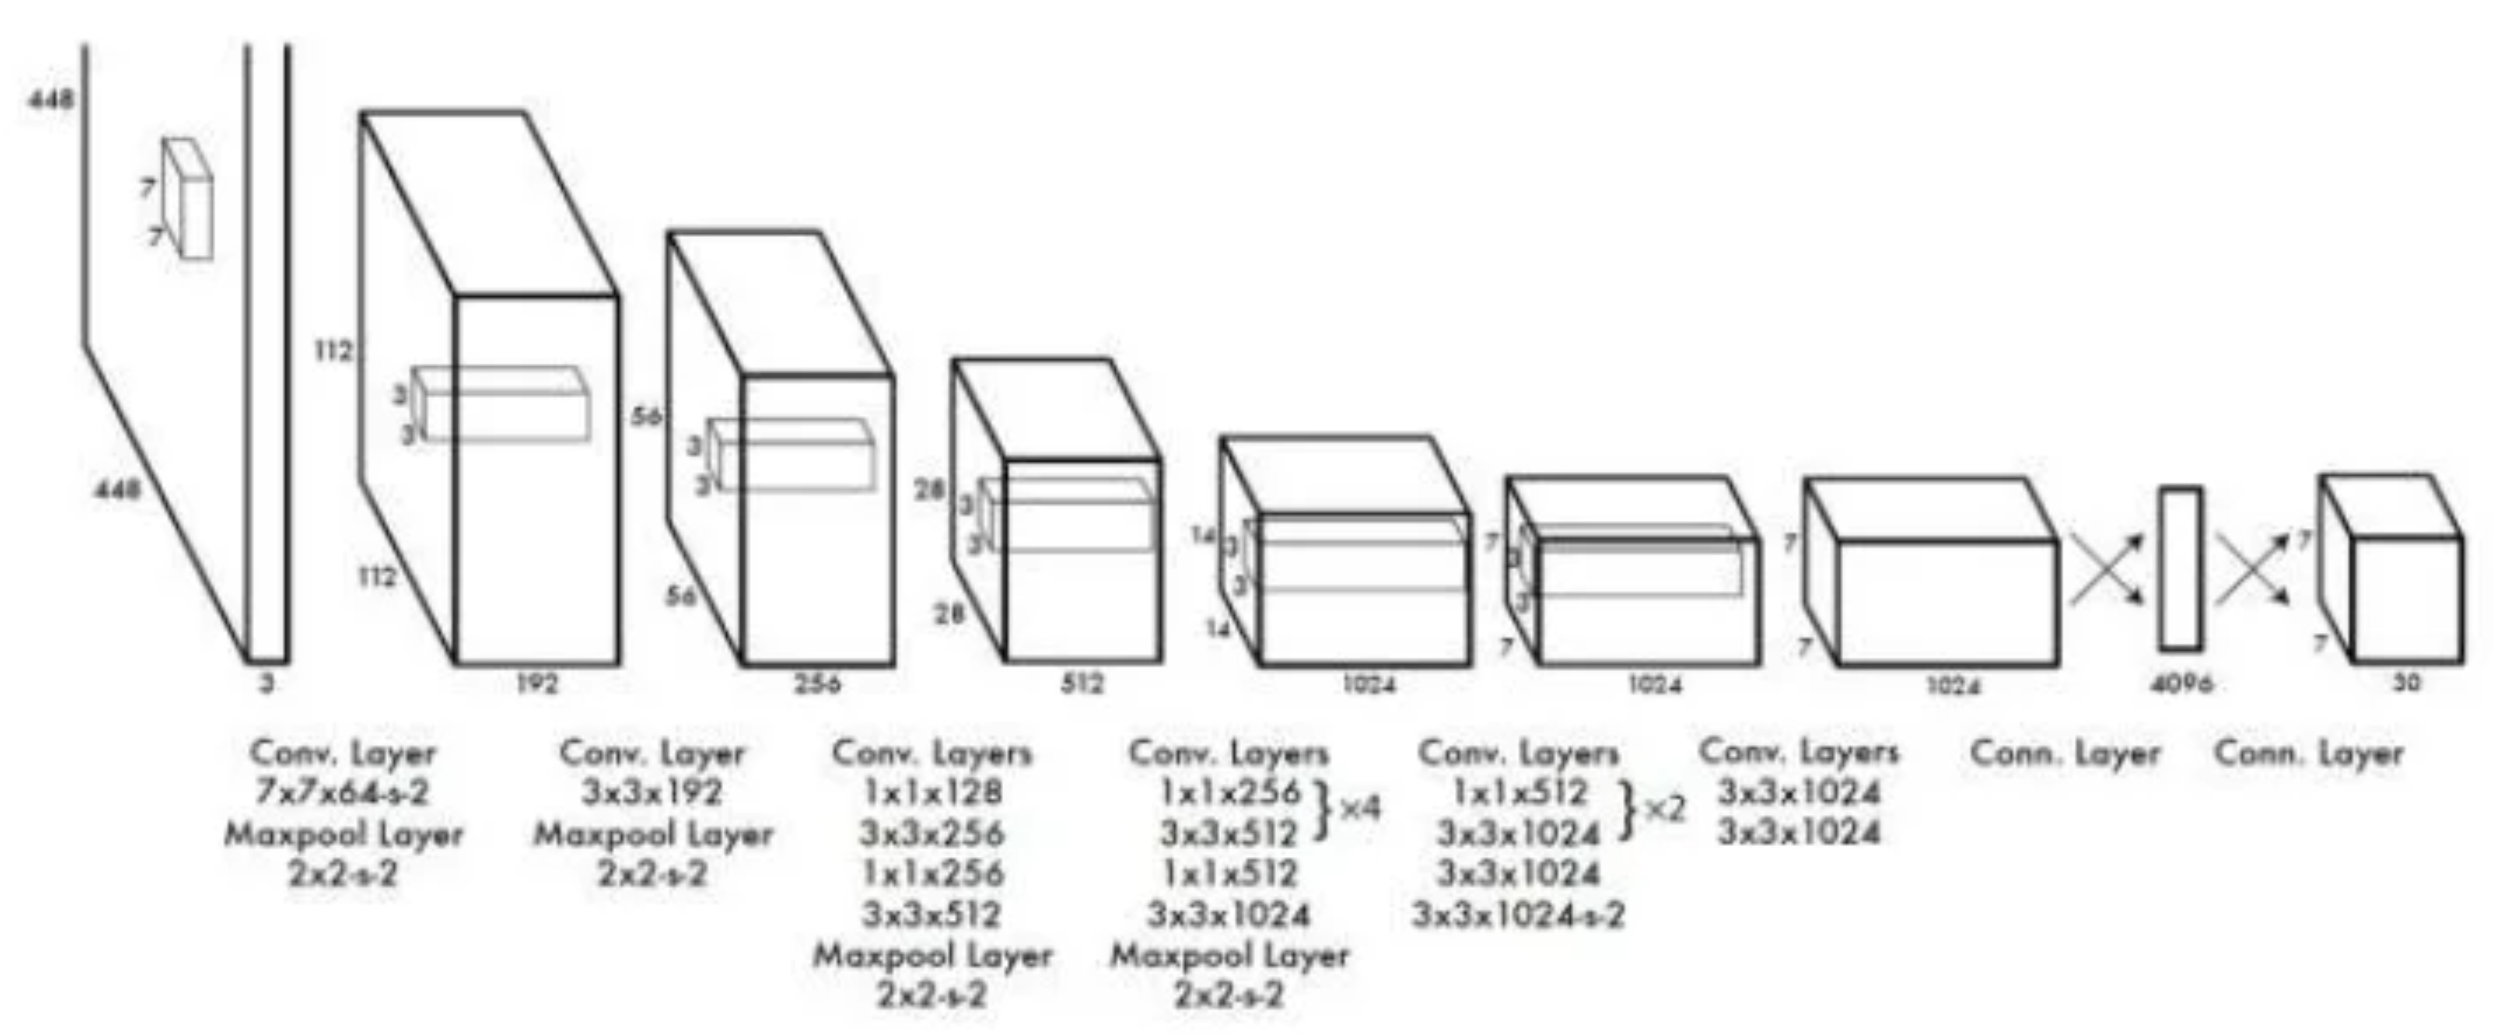



## YOLOX Architecture

## Proposed Architecture

> The author has chosen `Yolov3` with `Darknet-53` as the baseline architecture

- For the base Darknet-53 backbone with `SPP` layer is added, the author has made slight changes compared to original implementations which are the key points like
    - EMA updatation
    - Cosine LR scheduler
    - IOU loss with IOU aware branch
    - BCE loss for training cls and obj branch
    - IOU loss for training reg branch
    - RandomHorizontalFlip, ColorJitter, and Multiscale are considered for data augmentation.
    
- Decoupled head

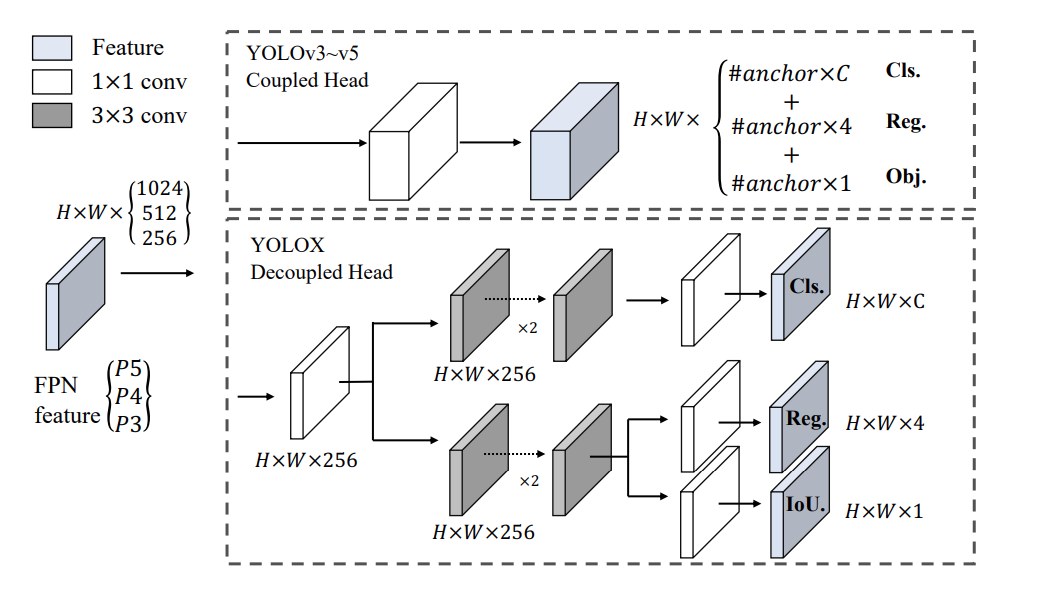

```note
Concretely, it contains a 1 × 1 conv layer to reduce the channel dimension, followed by two parallel branches with two 3 × 3 conv layers respectively.
```

- Anchor free
    - Concretely, it contains a `1 × 1` conv layer to reduce the channel dimension, followed by two parallel branches with two `3 × 3` conv layers respectively.
    - The center location of each object as the positive sample and pre-define a scale range, to designate the `FPN` level for each object which greatly reduces the computation cost and improves accuracy.


# Other Implementations

### NAS-FPN

- NAS is Neural Architectural Search Space, known as NASNet. There is an `RNN` controller to select best model architectures in a given search space using *reinforcement learning*
- The RNN controller uses the accuracy of a child model in the search space as the **reward** to update its parameters. Through trial and error, the RNN controller learns to generate better architectures over time.
- For scalability of the FPN, during the search, the FPN is forced to repeat itself N times and then concatenated into a large architecture

### Teacher Student (`KD`)

- **Knowledge Distillation** (KD) is a technique for improving accuracy of a small network (student), by transferring distilled knowledge produced by a large network (teacher). We can also say that KD is for compressing model (teacher → student) with minimal accuracy loss.

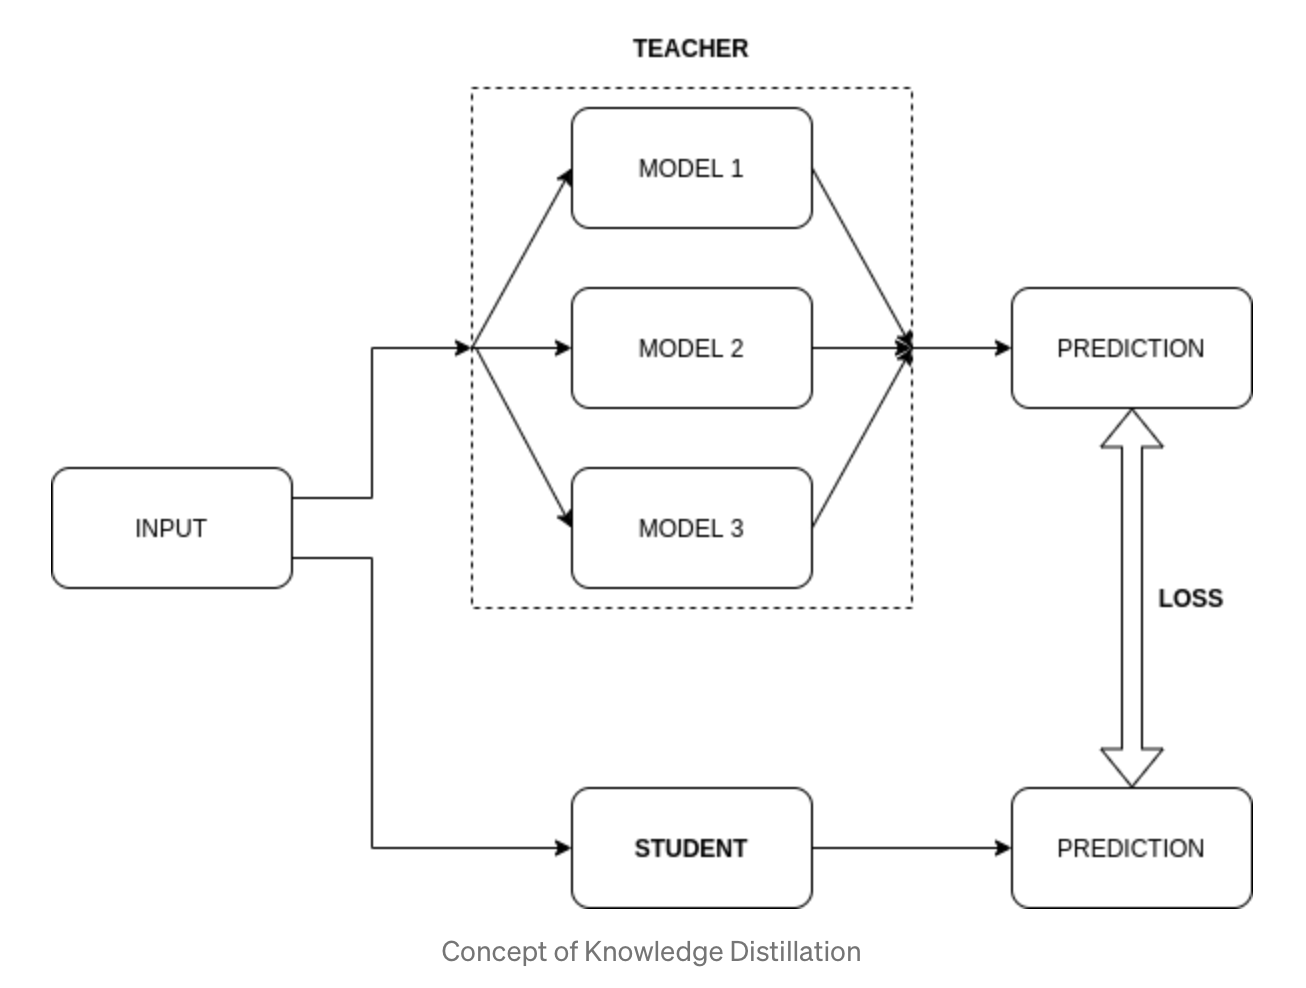

- Loss for soft target

$$
q_i = \frac{exp(z_i/T)}{\sum_j exp(z_i/T)}
$$

q_i : class score <br>
z_i : logit <br>
T: Temperature <br>




# Building the `CNN` from scratch

In [18]:
# import statements
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# Building Network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [6]:
network

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [7]:
# Reading data or downloading data for `MNIST`

In [8]:
from tqdm import tqdm
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting files/MNIST/raw/train-images-idx3-ubyte.gz to files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting files/MNIST/raw/train-labels-idx1-ubyte.gz to files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting files/MNIST/raw/t10k-images-idx3-ubyte.gz to files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting files/MNIST/raw/t10k-labels-idx1-ubyte.gz to files/MNIST/raw



In [9]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [10]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [11]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [13]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/var/folders/0s/jymfp69j54n12w613ymxj7vr0000gn/T/ipykernel_67817/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3283, Accuracy: 1138/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.339568
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.295768
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.301867
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.272979
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.261569
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.198385
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.245474
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.115467
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.067695
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.070717
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.150691
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.868738
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.775315
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.755243
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.896832
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.473969
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.324796
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.244336
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.298995
Train Epoch: 1 [12160

In [14]:
# Evaluating model performance

In [23]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

ValueError: x and y must be the same size

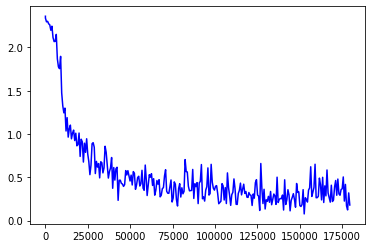

In [24]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [21]:
# Testing the trained-models

In [25]:
with torch.no_grad():
    output = network(example_data)

/var/folders/0s/jymfp69j54n12w613ymxj7vr0000gn/T/ipykernel_67817/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


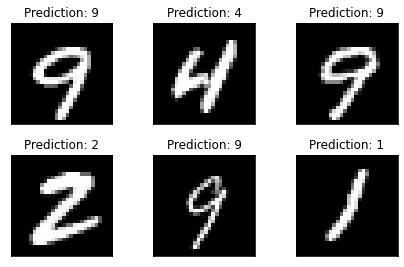

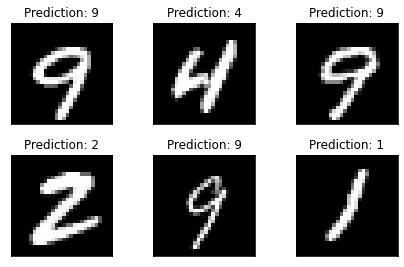

In [26]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig